# Bitcoin price prediction with RNN

## 환경 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/강의자료/WordEmb_RNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/강의자료/WordEmb_RNN


In [2]:
import torch

In [126]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 데이터 가져오기

In [127]:
import pandas as pd

In [128]:
rawdata = pd.read_csv("data/BTC-KRW.csv", index_col = "Date")

In [129]:
rawdata.index = pd.to_datetime(rawdata.index)

In [130]:
rawdata.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-11,7411982.5,7697034.5,6947920.0,7119685.5,7119685.5,5497083686613
2017-11-12,7050086.0,7419194.5,6180573.5,6654439.0,6654439.0,10017720967738
2017-11-13,6641220.0,7619610.0,6555540.0,7343087.0,7343087.0,7011457755445
2017-11-14,7345314.5,7559865.0,7198583.5,7404236.0,7404236.0,3567367326951
2017-11-15,7403131.5,8110543.0,7400411.0,8091133.5,8091133.5,4646257439171


In [131]:
df = rawdata[["Open"]]
df.columns = ["Price"]

In [132]:
df

,Price
Date,
2017-11-11,7411982.5
2017-11-12,7050086.0
2017-11-13,6641220.0
2017-11-14,7345314.5
2017-11-15,7403131.5
...,...
2021-12-21,55807092.0
2021-12-22,58300964.0
2021-12-23,57765908.0


In [133]:
df["Price"].isnull().sum()

0

In [134]:
df.index.inferred_type

'datetime64'

In [135]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [18, 6]
plt.rcParams["figure.autolayout"] = True

In [136]:
df

,Price
Date,
2017-11-11,7411982.5
2017-11-12,7050086.0
2017-11-13,6641220.0
2017-11-14,7345314.5
2017-11-15,7403131.5
...,...
2021-12-21,55807092.0
2021-12-22,58300964.0
2021-12-23,57765908.0


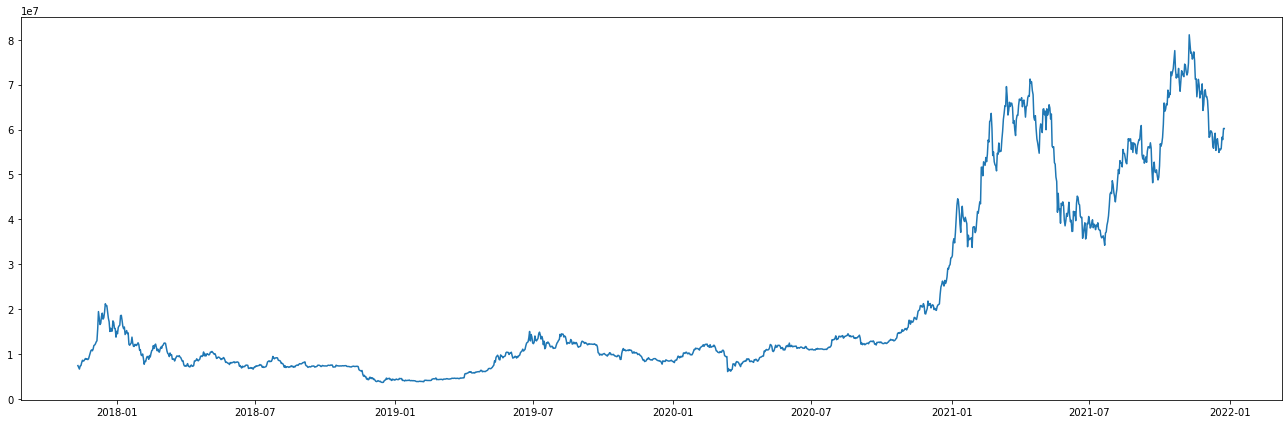

In [137]:
locator = mdates.AutoDateLocator()
formatter = mdates.AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.plot(df)
plt.show()

## 데이터 준비

In [138]:
from sklearn.model_selection import train_test_split

In [139]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle = False)
df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle = False)

In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_train)

df_train, df_val, df_test = scaler.transform(df_train), scaler.transform(df_val), scaler.transform(df_test)

In [141]:
len(df_train), len(df_val), len(df_test)

(1219, 136, 151)

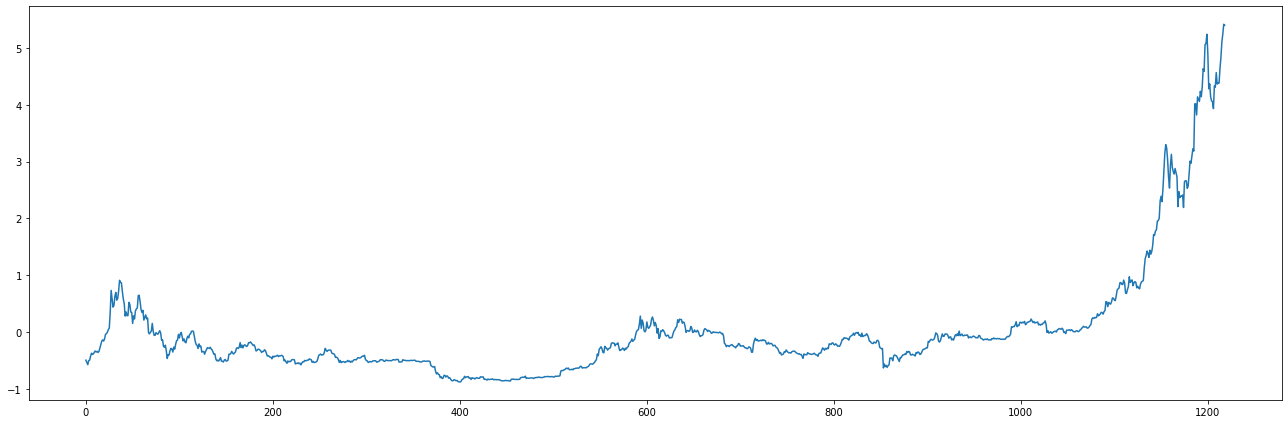

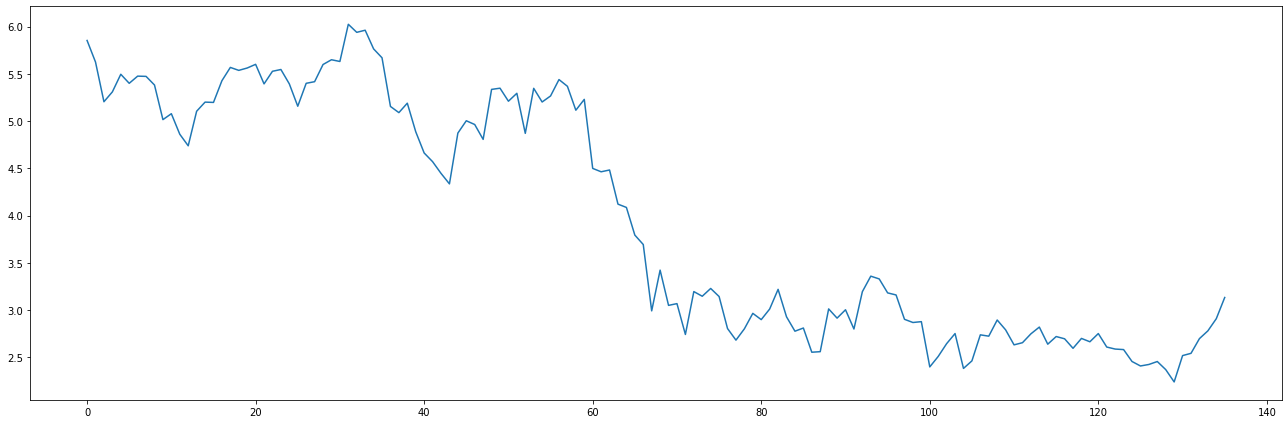

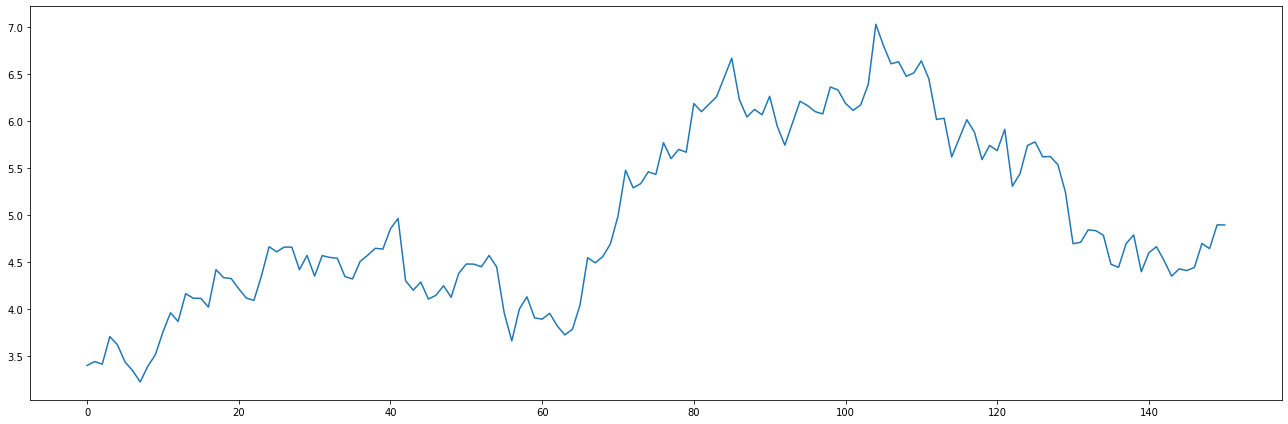

In [142]:
plt.plot(df_train)
plt.show()
plt.plot(df_val)
plt.show()
plt.plot(df_test)
plt.show()

In [143]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np

In [144]:
INPUT_LENGTH = 24
OUTPUT_LENGTH = 1
BATCH_SIZE = 64

In [145]:
class BitcoinDataset(Dataset):
    def __init__(self, df, input_length, output_length):
        self.df_raw = df
        self.input_length = input_length
        self.output_length = output_length
        assert len(df) > input_length + output_length
        self.x = []
        self.y = []

        total = len(df)
        for idx in range(input_length, total-output_length):
            self.x.append(self.df_raw[idx-input_length:idx])
            self.y.append(self.df_raw[idx:idx+output_length])

        self.x, self.y = np.array(self.x), np.array(self.y)
        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].float(), self.y[idx].float()

In [146]:
datasets = {}
datasets["train"] = BitcoinDataset(df_train, input_length = INPUT_LENGTH, output_length = OUTPUT_LENGTH)
datasets["val"] = BitcoinDataset(df_val, input_length = INPUT_LENGTH, output_length = OUTPUT_LENGTH)
datasets["test"] = BitcoinDataset(df_test, input_length = INPUT_LENGTH, output_length = OUTPUT_LENGTH)

In [147]:
sample_x, sample_y = datasets["train"][0]

In [148]:
sample_x.shape, sample_y.shape

(torch.Size([24, 1]), torch.Size([1, 1]))

In [149]:
loaders = {}
loaders["train"] = DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True)
loaders["train_no_shuffle"] = DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=False)
loaders["val"] = DataLoader(datasets["val"], batch_size=BATCH_SIZE, shuffle=False)
loaders["test"] = DataLoader(datasets["test"], batch_size=BATCH_SIZE, shuffle=False)

In [151]:
class MyReallyAwesomeBitcoinModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x):
        output, (hidden, cell) = self.rnn(x)
        last_hidden_state = output[:, -1, :]
        final_output = self.linear(last_hidden_state)
        return final_output

In [152]:
input_size = 1
hidden_size = 128
model = MyReallyAwesomeBitcoinModel(input_size = input_size, hidden_size = hidden_size)
model.to(device)

MyReallyAwesomeBitcoinModel(
  (rnn): LSTM(1, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [153]:
learning_rate = 1e-3
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [154]:
device

device(type='cuda', index=0)

In [155]:
train_loss_hist = []
val_loss_hist = []

for epoch in range(1, epochs+1):
    
    # Train
    train_loss = 0.0
    for x, y in loaders["train"]:
        x, y = x.to(device), y.to(device).view(-1, 1)
        y_pred = model(x)
        
        optimizer.zero_grad()
        loss = criterion(y, y_pred)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss / len(loaders["train"])
    train_loss_hist.append(train_loss)

    # Val
    with torch.no_grad():
        val_loss = 0.0
        for x, y in loaders["val"]:
            x, y = x.to(device), y.to(device).view(-1, 1)
            y_pred = model(x)
            
            val_loss += loss.item()
        val_loss = val_loss / len(loaders["val"])

    val_loss_hist.append(val_loss)
    print(f"EPOCH {epoch} | train loss {train_loss}, val loss {val_loss}")

EPOCH 1 | train loss 0.6209703464257089, val loss 0.1636234074831009
EPOCH 2 | train loss 0.10852768821151633, val loss 0.05850643292069435
EPOCH 3 | train loss 0.0599654136519683, val loss 0.028633538633584976
EPOCH 4 | train loss 0.032429863502712625, val loss 0.08386502414941788
EPOCH 5 | train loss 0.019477020042311204, val loss 0.011001459322869778
EPOCH 6 | train loss 0.022306317610568123, val loss 0.07823551446199417
EPOCH 7 | train loss 0.019531524495074625, val loss 0.009138689376413822
EPOCH 8 | train loss 0.01750274691240568, val loss 0.008895297534763813
EPOCH 9 | train loss 0.015816675119200034, val loss 0.009504909627139568
EPOCH 10 | train loss 0.015082123566811023, val loss 0.019601019099354744
EPOCH 11 | train loss 0.013763301000979385, val loss 0.007178331725299358
EPOCH 12 | train loss 0.013768907219759728, val loss 0.009583201259374619
EPOCH 13 | train loss 0.013604042438888237, val loss 0.006465544458478689
EPOCH 14 | train loss 0.014078766904085091, val loss 0.017

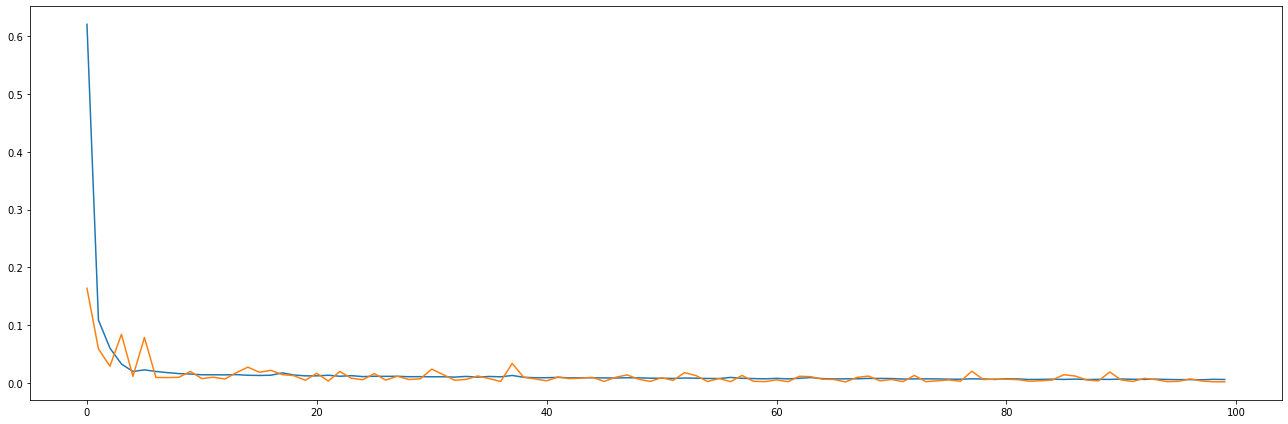

In [156]:
plt.plot(train_loss_hist)
plt.plot(val_loss_hist)
plt.show()

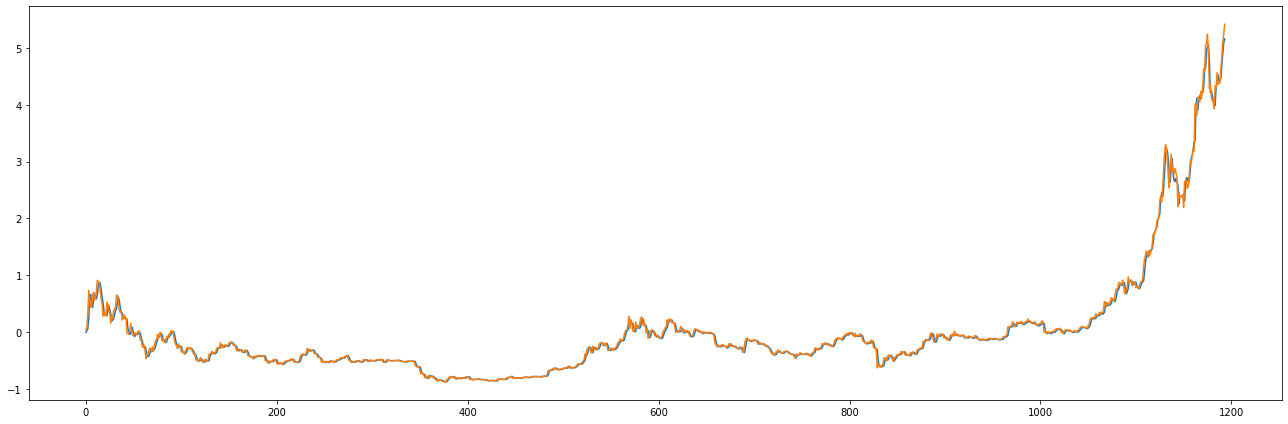

In [157]:
with torch.no_grad():
    y_pred = model(datasets["train"].x.to(device).float())

plt.plot(y_pred.cpu())
plt.plot(datasets["train"].y.view(-1))
plt.show()

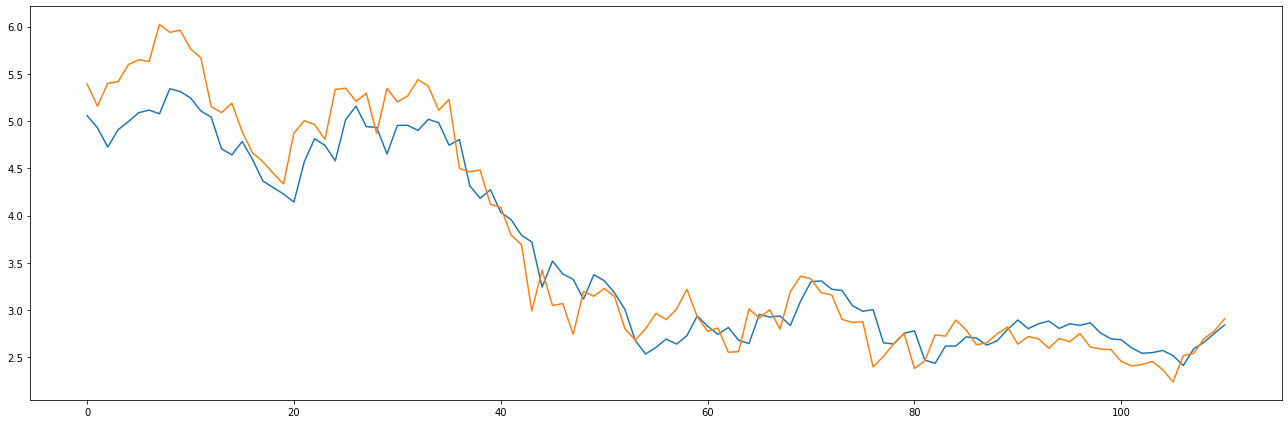

In [158]:
with torch.no_grad():
    y_pred = model(datasets["val"].x.to(device).float())

plt.plot(y_pred.cpu())
plt.plot(datasets["val"].y.view(-1))
plt.show()

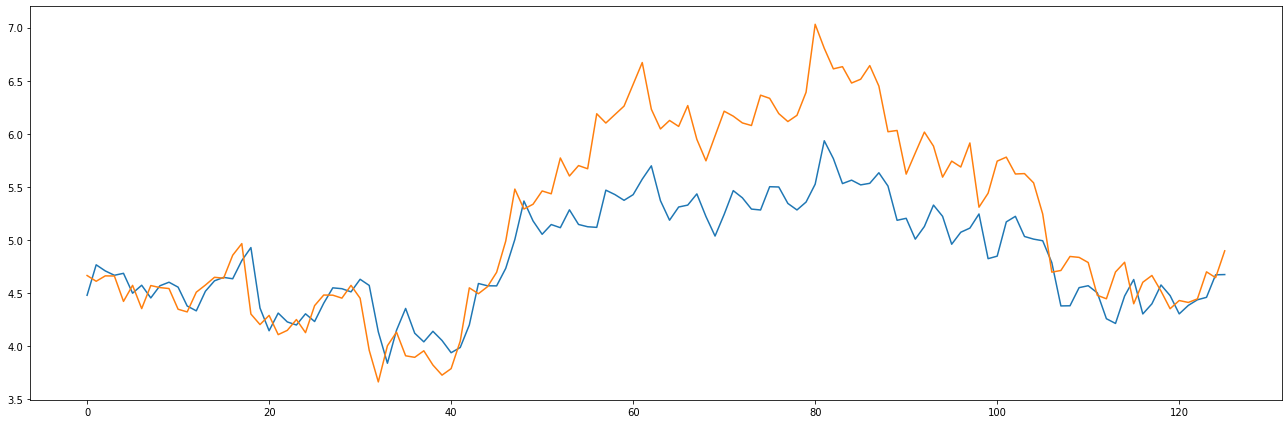

In [159]:
with torch.no_grad():
    y_pred = model(datasets["test"].x.to(device).float())

plt.plot(y_pred.cpu())
plt.plot(datasets["test"].y.view(-1))
plt.show()